In [177]:
import threading
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns


columns = ["Website",'test_name', 'HTTP status code', "Success", "Redirected to ISP Payload"]
df = pd.DataFrame(columns=columns)

text_file = "BlockingLists/russianWebsites.txt"


cyta_payload = "This site can’t be reached due tο compliance the Council Regulation (EU) 350/2022 and with EU and National Laws, only for as long as necessary."


def find_payload(text):
   if cyta_payload in text:
       return True
   else: 
       return False

In [178]:
import requests
import socket
import ssl

html_file_with_results = "result.html"
txt_file_with_results = "result.txt"
logs_file = "result.log"


def write_to_file(filename, data):
    with open(filename, "w") as f:
        f.write("%s\n" % data)


def _decode_bytes(input_bytes):
    return input_bytes.decode(errors="replace")


def send_request(
        host, port, data, html_file, txt_file,
        fragment_size=0, fragment_count=0, is_https=True):
    sock = socket.create_connection((host, port), 10)
    if is_https:
        context = ssl.create_default_context()
        sock = context.wrap_socket(sock, server_hostname=host)

    if fragment_count:
        sock.setsockopt(socket.IPPROTO_TCP, socket.TCP_NODELAY, True)

    try:
        for fragment in range(fragment_count):
            write_to_file(html_file, "fragment" + str(fragment))
            write_to_file(txt_file, "fragment" + str(fragment))

            sock.sendall(data[:fragment_size].encode())
            data = data[fragment_size:]

            write_to_file(html_file, str(data))
            write_to_file(txt_file, str(data))

        sock.sendall(data.encode())
        recvdata = sock.recv(8192)
        recv = recvdata
        recv_decoded = recv.decode()
        print(recv_decoded)
        write_to_file(logs_file, recv_decoded)
        write_to_file(html_file, recv_decoded)
        write_to_file(txt_file, recv_decoded)
        while recvdata:
            recvdata = sock.recv(8192)
            recv += recvdata
    finally:
        try:
            sock.shutdown(socket.SHUT_RDWR)
        except  Exception:
            print("Exception occurred")
        sock.close()
    return _decode_bytes(recv)


def configure_request_body(host, urn="/"):
    requests_body = {
        "normal one ": {
            "data": "GET {} HTTP/1.1\r\n".format(urn)
                    + "Host: {}\r\nConnection: close\r\n\r\n".format(host),
            "fragment_size": 0,
            "fragment_count": 0,
        },
        "extra space after  GET": {
            "data": "GET  {} HTTP/1.0\r\n".format(urn)
                    + "Host: {}\r\nConnection: close\r\n\r\n".format(host),
            "fragment_size": 0,
            "fragment_count": 0,
        },
        "extra line break after GET": {
            "data": "\r\nGET {} HTTP/1.0\r\n".format(urn)
                    + "Host: {}\r\nConnection: close\r\n\r\n".format(host),
            "fragment_size": 0,
            "fragment_count": 0,
        },
        "tab sign after hostname": {
            "data": "GET {} HTTP/1.0\r\n".format(urn)
                    + "Host: {}\t\r\nConnection: close\r\n\r\n".format(host),
            "fragment_size": 0,
            "fragment_count": 0,
        },
        "fragmented header": {
            "data": "GET {} HTTP/1.0\r\n".format(urn)
                    + "Host: {}\r\nConnection: close\r\n\r\n".format(host),
            "fragment_size": 2,
            "fragment_count": 6,
        },
        "dot after hostname": {
            "data": "GET {} HTTP/1.0\r\n".format(urn)
                    + "Host: {}.\r\nConnection: close\r\n\r\n".format(host),
            "fragment_size": 0,
            "fragment_count": 0,
        },
        " hoSt instead Host": {
            "data": "GET {} HTTP/1.0\r\n".format(urn)
                    + "hoSt: {}\r\nConnection: close\r\n\r\n".format(host),
            "fragment_size": 0,
            "fragment_count": 0,
        },
        " hOSt instead Host": {
            "data": "GET {} HTTP/1.0\r\n".format(urn)
                    + "hOSt: {}\r\nConnection: close\r\n\r\n".format(host),
            "fragment_size": 0,
            "fragment_count": 0,
        },
        " Hostname with uppercase": {
            "data": "GET {} HTTP/1.0\r\n".format(urn)
                    + "Host: {}\r\nConnection: close\r\n\r\n".format(host.upper()),
            "fragment_size": 0,
            "fragment_count": 0,
        },
        "missing space sign after Host:": {
            "data": "GET {} HTTP/1.0\r\n".format(urn)
                    + "Host:{}\r\nConnection: close\r\n\r\n".format(host),
            "fragment_size": 0,
            "fragment_count": 0,
        },
        "unix style line break in header": {
            "data": "GET {} HTTP/1.0\n".format(urn)
                    + "Host: {}\nConnection: close\n\n".format(host),
            "fragment_size": 0,
            "fragment_count": 0,
        },
        "unusual order of connection and hostname": {
            "data": "GET {} HTTP/1.0\r\n".format(urn)
                    + "Connection: close\r\nHost: {}\r\n\r\n".format(host),
            "fragment_size": 0,
            "fragment_count": 0,
        },
        "fragmented header, hoSt and missed space": {
            "data": "GET {} HTTP/1.0\r\n".format(urn)
                    + "hoSt:{}\r\nConnection: close\r\n\r\n".format(host),
            "fragment_size": 2,
            "fragment_count": 6,
        },
    }
    return requests_body


def test_dpi(site, port, html_file=html_file_with_results,
             txt_file=txt_file_with_results, is_https=False):
    results = []
    configured_requests = configure_request_body(site, "/")
    for test_name in sorted(configured_requests):
        test = configured_requests[test_name]
        try:
            result = send_request(
                site,
                port,
                test.get("data"),
                html_file,
                txt_file,
                test.get("fragment_size"),
                test.get("fragment_count"),
                is_https,
            )
            df.loc[len(df)] = {
                "Website": site,
                "test_name": test_name,
                "HTTP status code": result.split("\n")[0],
                "Success": result.split("\n")[0].find("200 ") != -1,
                "Redirected to ISP Payload": find_payload(result)
            }
            df.reset_index(drop=True)
            for i in range(len(result.split("\n"))):
                print(f"fdsfsdf: {i}", result.split("\n")[i])


        except Exception as e:
            print("🤬 error: ", repr(e))
        else:
            if result.split("\n")[0].find("200 ") != -1:
                print("😘 open successfully")
                results.append((test_name,result))
            else:
                print("😒 can't open")
    return list(set(results))


def trucate_https(domain):
    domain = domain.replace("https://", "")
    domain = domain.replace("http://", "")
    domain = domain.replace("www.", "")
    if domain.endswith("/"):
        domain = domain[:-1]
    return domain


def get_redirection(url, timeout=3):
    try:
            response = requests.get(f"http://{url}", allow_redirects=False)
    except requests.exceptions.ConnectTimeout:
            print("Connection timed out while trying to reach the server.")
            return None, False
    max_redirects = 10
    num_redirects = 0
    redirect_url = f"http://{url}"
    is_https = False
    while response.is_redirect or response.is_permanent_redirect:
        if num_redirects >= max_redirects:
            print("Reached maximum number of redirects.")
            break

        redirect_url = response.headers['Location']
        if redirect_url.find("https") != -1:
            is_https = True
        print(f"Redirecting to: {redirect_url}")
        try:
            response = requests.get(redirect_url, allow_redirects=False, timeout=timeout)
        except requests.exceptions.ConnectTimeout:
            print("Connection timed out while trying to reach the server.")
            return None, False
        except requests.exceptions.RequestException as e:
            print(f"An error occurred: {e}")
            return None, False
        num_redirects += 1
    redirect_url = trucate_https(redirect_url)
    print(redirect_url)
    return redirect_url, is_https


def test_http_or_https(site):
    site, is_https_required = get_redirection(site)
    if is_https_required:
        port = 443
    else:
        port = 80
    return test_dpi(site, port=port, is_https=is_https_required)




In [179]:

def parse_http_response(response_text):
    headers = {}
    lines = response_text.split('\n')
    status_line = lines[0].strip()
    headers['HTTP Status'] = status_line

    for line in lines[1:]:
        line = line.strip()
        if not line:
            break
        if ':' in line:
            key, value = line.split(':', 1)
            headers[key.strip()] = value.strip()
        else:
            headers[line] = None

    return headers


def test_sites_from_file(filename):
    with open(filename, "r") as file:
        websites = [line.strip() for line in file]

    threads = []
    for site in websites:
        thread = threading.Thread(target=process_site, args=(site,))
        thread.start()
        threads.append(thread)
    for thread in threads:
        thread.join()


def process_site(site):
    test_http_or_https(site)
    response = test_http_or_https(site)
    # parsed_headers = parse_http_response(response)
    # add_to_dataframe(parsed_headers)


test_sites_from_file(text_file)     

vk.com
regnum.ru
HTTP/1.1 200 OK
Date: Sat, 20 Apr 2024 14:47:50 GMT
Server: Apache
Last-Modified: Tue, 10 May 2022 07:25:00 GMT
ETag: "4c9-5dea338f26b00"
Accept-Ranges: bytes
Content-Length: 1225
Connection: close
Content-Type: text/html

<!doctype html>
<html>
<head>
<meta charset="utf-8">
<title>Cyta</title>
<meta name="viewport" content="width=device-width, initial-scale=1" />
<link rel="shortcut icon" type="image/x-icon" href="favicon.ico" />	
<style>
body {
    font-family: Arial, sans-serif;
    font-size: 22px;
    background-color: #efefef;
	 color: #333;
    background-image: none;
    height: 100%;
	line-height: 30px;
	padding: 80px 0;
}
a {
    color: #357729;
    text-decoration: underline;
}
a:hover {
    color: #666;
    text-decoration: underline;
}
.table{
	background-color: #fff;
	border-radius: 8px;
	box-shadow: 0 2px 8px 0 rgb(0 0 0 / 16%);
	padding: 50px;
	width: 96%;
	max-width: 850px;
}	
</style>
</head>

<body>

<p style="text-align: center;"><img src="cyta-logo

Exception in thread Thread-94 (process_site):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/dmitrii/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_7250/2293035172.py", line 34, in process_site
  File "/tmp/ipykernel_7250/359536350.py", line 233, in test_http_or_https
  File "/tmp/ipykernel_7250/359536350.py", line 148, in test_dpi
  File "/tmp/ipykernel_7250/359536350.py", line 113, in configure_request_body
AttributeError: 'NoneType' object has no attribute 'upper'


🤬 error:  ValueError('Shape of passed values is (31, 5), indices imply (30, 5)')
fdsfsdf: 0 HTTP/1.1 200 OK
fdsfsdf: 1 Date: Sat, 20 Apr 2024 14:47:50 GMT
fdsfsdf: 2 Server: Apache
fdsfsdf: 3 Last-Modified: Tue, 10 May 2022 07:25:00 GMT
fdsfsdf: 4 ETag: "4c9-5dea338f26b00"
fdsfsdf: 5 Accept-Ranges: bytes
fdsfsdf: 6 Content-Length: 1225
fdsfsdf: 7 Connection: close
fdsfsdf: 8 Content-Type: text/html
fdsfsdf: 9 
fdsfsdf: 10 <!doctype html>
fdsfsdf: 11 <html>
fdsfsdf: 12 <head>
fdsfsdf: 13 <meta charset="utf-8">
fdsfsdf: 14 <title>Cyta</title>
fdsfsdf: 15 <meta name="viewport" content="width=device-width, initial-scale=1" />
fdsfsdf: 16 <link rel="shortcut icon" type="image/x-icon" href="favicon.ico" />	
fdsfsdf: 17 <style>
fdsfsdf: 18 body {
fdsfsdf: 19     font-family: Arial, sans-serif;
fdsfsdf: 20     font-size: 22px;
fdsfsdf: 21     background-color: #efefef;
fdsfsdf: 22 	 color: #333;
fdsfsdf: 23     background-image: none;
fdsfsdf: 24     height: 100%;
fdsfsdf: 25 	line-height: 30p

Exception in thread Thread-99 (process_site):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/dmitrii/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_7250/2293035172.py", line 34, in process_site
  File "/tmp/ipykernel_7250/359536350.py", line 233, in test_http_or_https
  File "/tmp/ipykernel_7250/359536350.py", line 148, in test_dpi
  File "/tmp/ipykernel_7250/359536350.py", line 113, in configure_request_body
AttributeError: 'NoneType' object has no attribute 'upper'


An error occurred: HTTPSConnectionPool(host='admburla.ru', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate in certificate chain (_ssl.c:1007)')))
HTTP/1.1 200 OK
Server: nginx
Date: Sat, 20 Apr 2024 14:47:52 GMT
Content-Type: text/html
Content-Length: 8947
Connection: close
Keep-Alive: timeout=10
Last-Modified: Fri, 04 Mar 2022 21:27:53 GMT
ETag: "62228459-22f3"
Expires: Sat, 20 Apr 2024 14:47:51 GMT
Cache-Control: no-cache
Accept-Ranges: bytes
Strict-Transport-Security: max-age=16070400

<!doctype html>
<html lang="en">
<head>
    <meta http-equiv="X-UA-Compatible" content="IE=edge" />
    <meta charset="utf-8">
    <title>Портал государственных услуг Российской Федерации</title>
    <base href="/">
    <link rel="preload" href="https://gu-st.ru/portal-st/lib-assets/fonts/Lato-Regular.woff2" as="font"
        type="font/woff2" crossorigin="">
    <link rel="

Exception in thread Thread-100 (process_site):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
Exception in thread Thread-101 (process_site):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
Exception in thread Thread-93 (process_site):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
Exception in thread Thread-98 (process_site):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/dmitrii/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self.run()
  File "/home/dmitrii/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    self.run()
  File "/home/dmitrii/.loca

Connection timed out while trying to reach the server.
Connection timed out while trying to reach the server.
Connection timed out while trying to reach the server.
Connection timed out while trying to reach the server.
🤬 error:  TimeoutError('timed out')
🤬 error:  TimeoutError('timed out')
🤬 error:  TimeoutError('timed out')
🤬 error:  TimeoutError('timed out')
🤬 error:  TimeoutError('timed out')
🤬 error:  TimeoutError('timed out')
🤬 error:  TimeoutError('timed out')
🤬 error:  TimeoutError('timed out')
🤬 error:  TimeoutError('timed out')
🤬 error:  TimeoutError('timed out')
🤬 error:  TimeoutError('timed out')
🤬 error:  TimeoutError('timed out')
🤬 error:  TimeoutError('timed out')
🤬 error:  TimeoutError('timed out')
🤬 error:  TimeoutError('timed out')
🤬 error:  TimeoutError('timed out')
🤬 error:  TimeoutError('timed out')


Exception in thread Thread-91 (process_site):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/dmitrii/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_7250/2293035172.py", line 35, in process_site
  File "/tmp/ipykernel_7250/359536350.py", line 233, in test_http_or_https
  File "/tmp/ipykernel_7250/359536350.py", line 148, in test_dpi
  File "/tmp/ipykernel_7250/359536350.py", line 113, in configure_request_body
AttributeError: 'NoneType' object has no attribute 'upper'


Connection timed out while trying to reach the server.


KeyboardInterrupt: 

In [ ]:
# df

In [180]:
df.head()

,Website,test_name,HTTP status code,Success,Redirected to ISP Payload
0,vk.com,Hostname with uppercase,HTTP/1.1 200 OK\r,True,False
1,vk.com,hOSt instead Host,HTTP/1.1 200 OK\r,True,False
2,iz.ru,Hostname with uppercase,HTTP/1.1 200 OK\r,True,False
3,regnum.ru,Hostname with uppercase,HTTP/1.1 200 OK\r,True,False
4,ria.ru,Hostname with uppercase,HTTP/1.1 200 OK\r,True,False


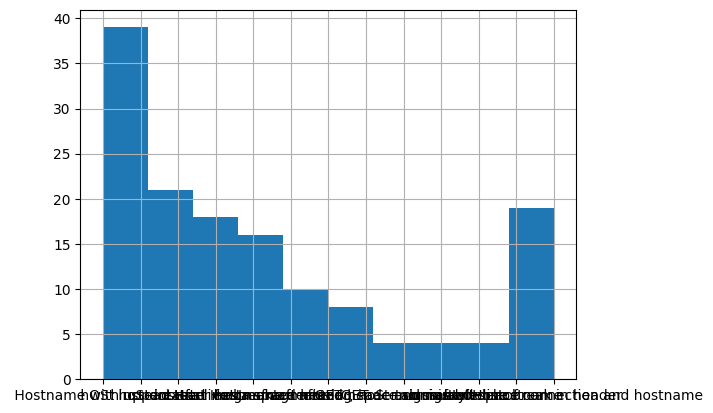

In [181]:
df['test_name'].hist()
plt.show()

In [182]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, y='Description', order=df['HTTP status code'].value_counts().index)
plt.title('Count of Different Descriptions')
plt.xlabel('Count')
plt.ylabel('Description')
plt.show()



ValueError: Could not interpret value `Description` for `y`. An entry with this name does not appear in `data`.

<Figure size 1000x600 with 0 Axes>

) missing from current font.hon3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


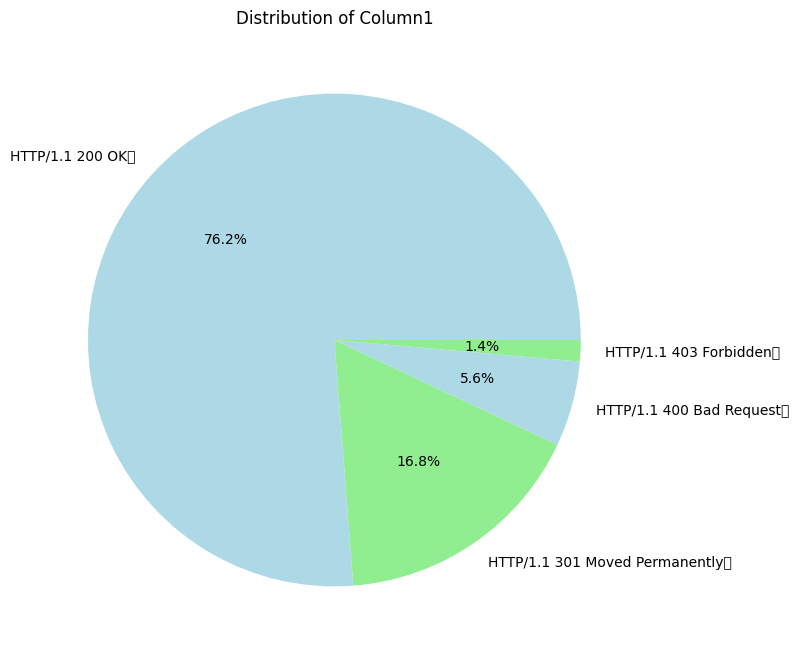

In [183]:
# Pie chart for column1 values
plt.figure(figsize=(8, 8))
df['HTTP status code'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['lightblue', 'lightgreen'])
plt.title('Distribution of Column1')
plt.ylabel('')
plt.show()



) missing from current font.hon3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


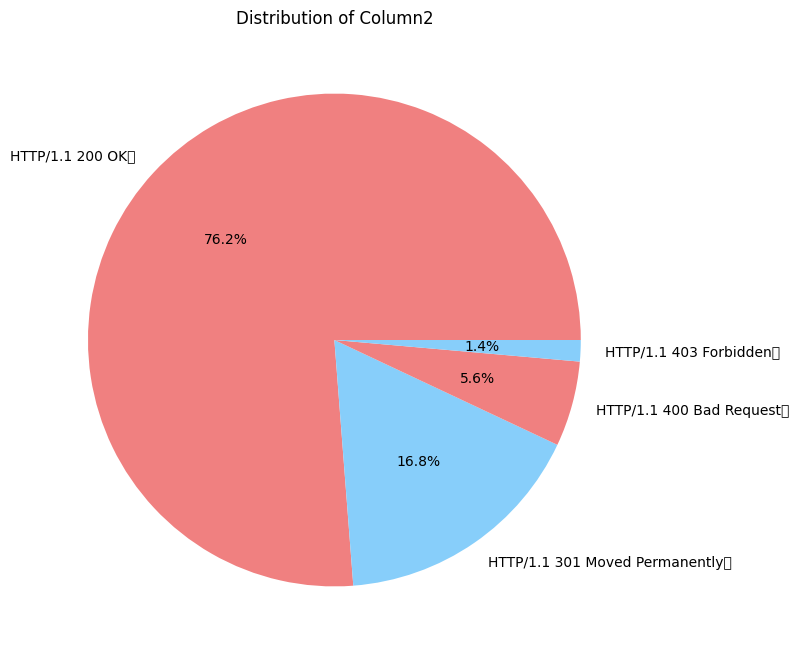

In [184]:
plt.figure(figsize=(8, 8))
df['HTTP status code'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['lightcoral', 'lightskyblue'])
plt.title('Distribution of Column2')
plt.ylabel('')
plt.show()

) missing from current font.70.py:12: UserWarning: Glyph 13 (
  plt.tight_layout()
) missing from current font.hon3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


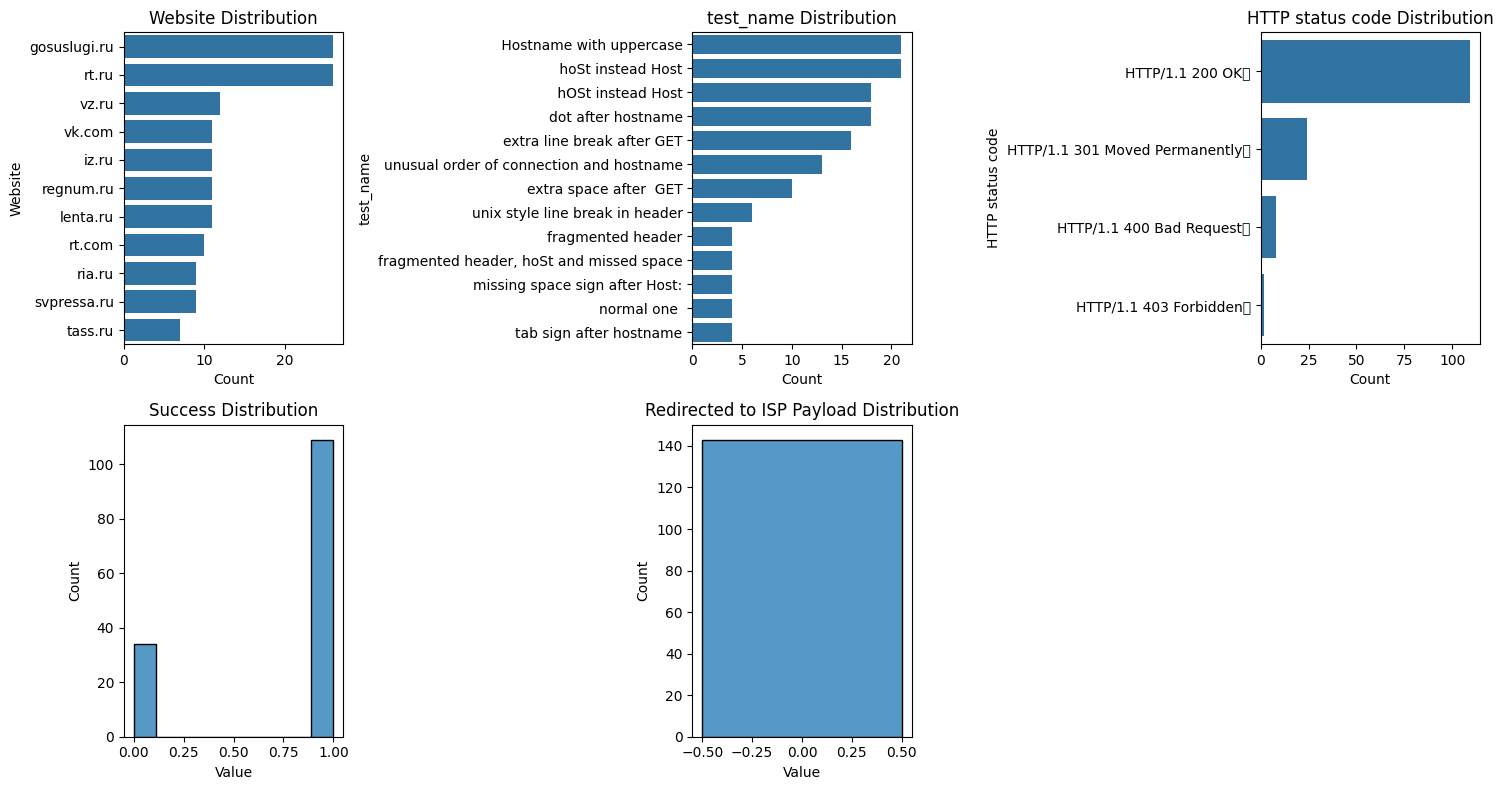

In [185]:
plt.figure(figsize=(15, 8))

for i, column in enumerate(df.columns):
    plt.subplot(2, 3, i+1)
    if df[column].dtype == 'object':
        sns.countplot(data=df, y=column, order=df[column].value_counts().index)
    else:
        sns.histplot(data=df, x=column)
    plt.title(f'{column} Distribution')
    plt.xlabel('Count' if df[column].dtype == 'object' else 'Value')

plt.tight_layout()
plt.show()